In [1]:
from iec import IECTester, IEC
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
from datetime import timedelta

In [2]:
#data = np.loadtxt("dataset.gz2")

dataset_filename = '../dataset.gz'
dataset_tz = 'Europe/Zurich'

data = pd.read_csv(dataset_filename, parse_dates=[0], index_col=0).tz_localize('UTC').tz_convert(dataset_tz)

# Initialize and run our tester.

In [3]:

MinutesInWeek = 10080

PredictionWindow = 720
TestingRange = range(PredictionWindow + MinutesInWeek*0, 
                     PredictionWindow + MinutesInWeek*4,
                     60)

tester = IECTester(data, PredictionWindow, TestingRange,
                   SaveFile=None)


In [4]:
tester.run('Baseline Finder', 'Simple Mean', 'Baseline Finder Hybrid',
           multithread=True)

100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [01:34<00:00,  7.13it/s]


In [ ]:
tester.save()

# <center>The Problem</center>

### Predicting future energy consumption minute by minute.

Given a specific time and historical information (non intrusive - aggregate consumption only) on a specific household, we try to predict the households usage.

Our tested prediction window will be 720 minutes (12 hours) ahead of the current time.


# <center>Algorithms</center>

## 1. Mean Usage
#### This simple algorithm finds the mean consumption the last few hours and predicts that consumption = mean. The algorithm is meant to work as a point of reference for our other benchmarks.


## 2. ACP
#### The ACP algorithm works by finding K days, in the household's historical data, where the consumption was similar to the current day. Then returns the mean consumption of those days.

## 3. Baseline Finder (BLF)
#### This algorithm takes into consideration the nature of the consumption vector. This vector has a base consumption and an amount of noise on top of it. The algorithm filters the daily consumption using a low pass filter, to find the base consumption. Then it finds similar days and makes a prediction again using the base consumption.  While this algorithm is excelent at finding the base consumption, it fails at predicting any spikes in the usage.

## 4. Usage Zone Finder (UZF)
#### Finally, the usage zone finder tries to improve on top of the baseline algorithm. Again using historical data it predicts the base consumption similary to BLF. Then it tries to match usage regions (or spikes) in the historical data, and if it is confident enough, it will predict a usage spike in similar times.

# <center> How everything works </center>

In [5]:
from test_plotters import PlotRMSEperMin, PlotAverageRMSE, PlotAverageTotalError, PlotSimplePrediction

In [ ]:
from iec import find_similar_days, cosine_similarity, baseline_similarity, mins_in_day

## I. Similarity

The first step of our algorithms was to locate days similar to the one we are looking to predict.

To solve this problem we begun by calculating an 'Observation vector', which had length length (Minutes in current day + 4*60)
This vector contained minute by minute information of consumption of the last few hours.

Then we aggregated this information to an interval (for example of 15 minutes) to create our final observation vector.

To continue we calculated for every similar time in our historical data (same time, similar weekday), an observation vector as described above. 

Sorting the times above based on the cosine similarity (at the beginning) and taking the K best times was the final step.

Below is an example of a random moment and the most similar day.

In [ ]:
offset = 2500
TrainingWindow = 24*60*60
TrainingData = data[-TrainingWindow-offset:-offset]
CurrentTime = TrainingData.index[-1]
ObservationLength = mins_in_day(CurrentTime) + (4 * 60)
obs_td = timedelta(minutes=ObservationLength)
prediction_td = timedelta(minutes=PredictionWindow)
interval = 15
K = 8
cons_col = 'House Consumption'

In [ ]:
KSimilarDays = find_similar_days(
            TrainingData,
            ObservationLength,
            K, interval,
            method=cosine_similarity)

data[CurrentTime-obs_td:CurrentTime+prediction_td][cons_col].plot()
plt.axvline(CurrentTime, color='r', linestyle='--')

similar_day = KSimilarDays[0]
fig = plt.figure()
TrainingData[similar_day-obs_td:similar_day+prediction_td][cons_col].plot()
plt.axvline(similar_day, color='r', linestyle='--')

We can also try to change the similarity method to one that takes into account the actual distance of the vectors (Cosine Similarity only takes into account the angle of the vectors.)
This method, that inspired BLF, takes into consideration only the base consumption of the day (with a low-pass filter).
Using this method we had significantly better results

In [ ]:
KSimilarDays = find_similar_days(
            TrainingData,
            ObservationLength,
            K, interval,
            method=baseline_similarity)

data[CurrentTime-obs_td:CurrentTime+prediction_td][cons_col].plot()
plt.axvline(CurrentTime, color='r', linestyle='--')

similar_day = KSimilarDays[0]
fig = plt.figure()
TrainingData[similar_day-obs_td:similar_day+prediction_td][cons_col].plot()
plt.axvline(similar_day, color='r', linestyle='--')

In [6]:
def PlotSimplePrediction(tester, offset, algorithms=None, axes=None):
    PredictionWindow = tester.PredictionWindow
    prediction = tester.simple_prediction(offset)
    variance = tester.results["Baseline Finder Hybrid STD"][offset, :]
    
    if algorithms is None:
        algorithms = tester.TestedAlgorithms
    if axes is None:
        fig, axes = plt.subplots(figsize=(20,10), dpi=400)

    for a in algorithms:
        label = a + " Prediction"
        axes.plot(range(PredictionWindow), prediction[a], label=label, linewidth=2)
        #print("RMSE of this ", a, " prediction is: ", mean_squared_error(prediction['GroundTruth'], prediction[a])**0.5)
        
        if a == "Baseline Finder Hybrid":
            plt.fill_between(range(PredictionWindow),
                     prediction[a] - 1.9600 * variance,
                     prediction[a] + 1.9600 * variance,
                     alpha=.5, color='b', edgecolor='None', label='95% confidence interval')


    axes.plot(range(PredictionWindow), prediction['GroundTruth'], label='Ground Truth', linewidth=2)

    axes.legend()

## II. ACP

The ACP prediction works by averaging consumption of previous similar days
A simple prediction looks like this:

KeyError: 'ACP'

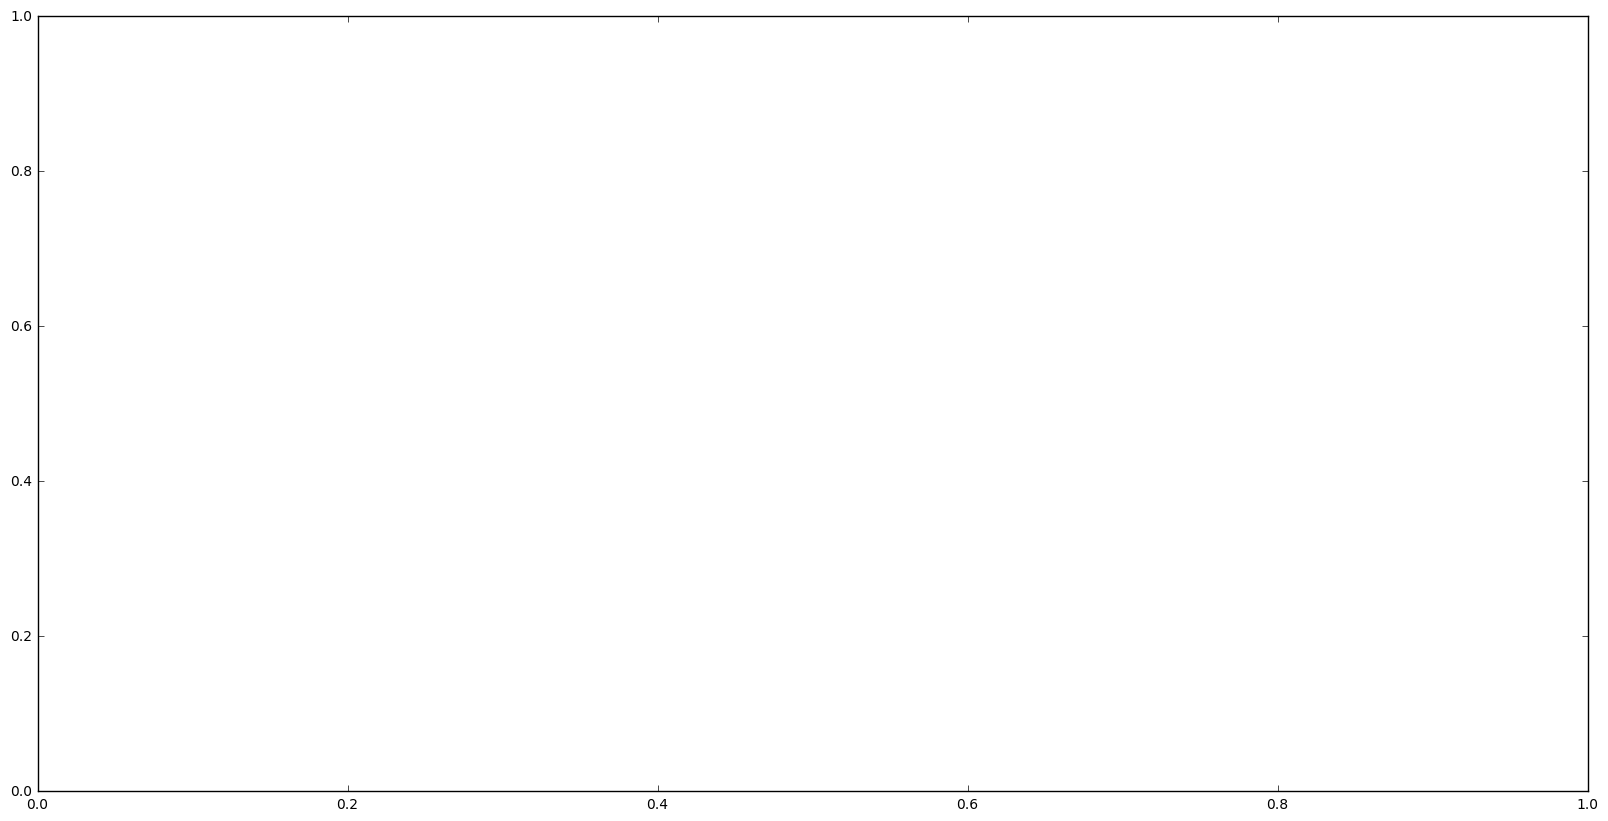

In [7]:
PlotSimplePrediction(tester, 20, {"ACP"})

## III. Baseline Finder

The Baseline Finder Algorithm works in a similar way with ACP, but it first passes the data from a low pass filter:

In [ ]:
from iec import med_filt
#fig, axes = plt.subplots(2, figsize=(20,8), dpi=400)

#axes[0].plot(data[-offset-ObservationLength:-offset, 2])
#axes[1].plot(med_filt(data[-offset-ObservationLength:-offset, 2],
#                     241))

#axes[1].set_ylim(axes[0].get_ylim())

This has the advantage that it filters high frequency spikes on consumption, that can't be easily predicted. This way the bulk of the energy consumption is predicted with high accuracy. Unfortunatelly we cannot predict spikes at all using this method.
A simple prediction using BLF:

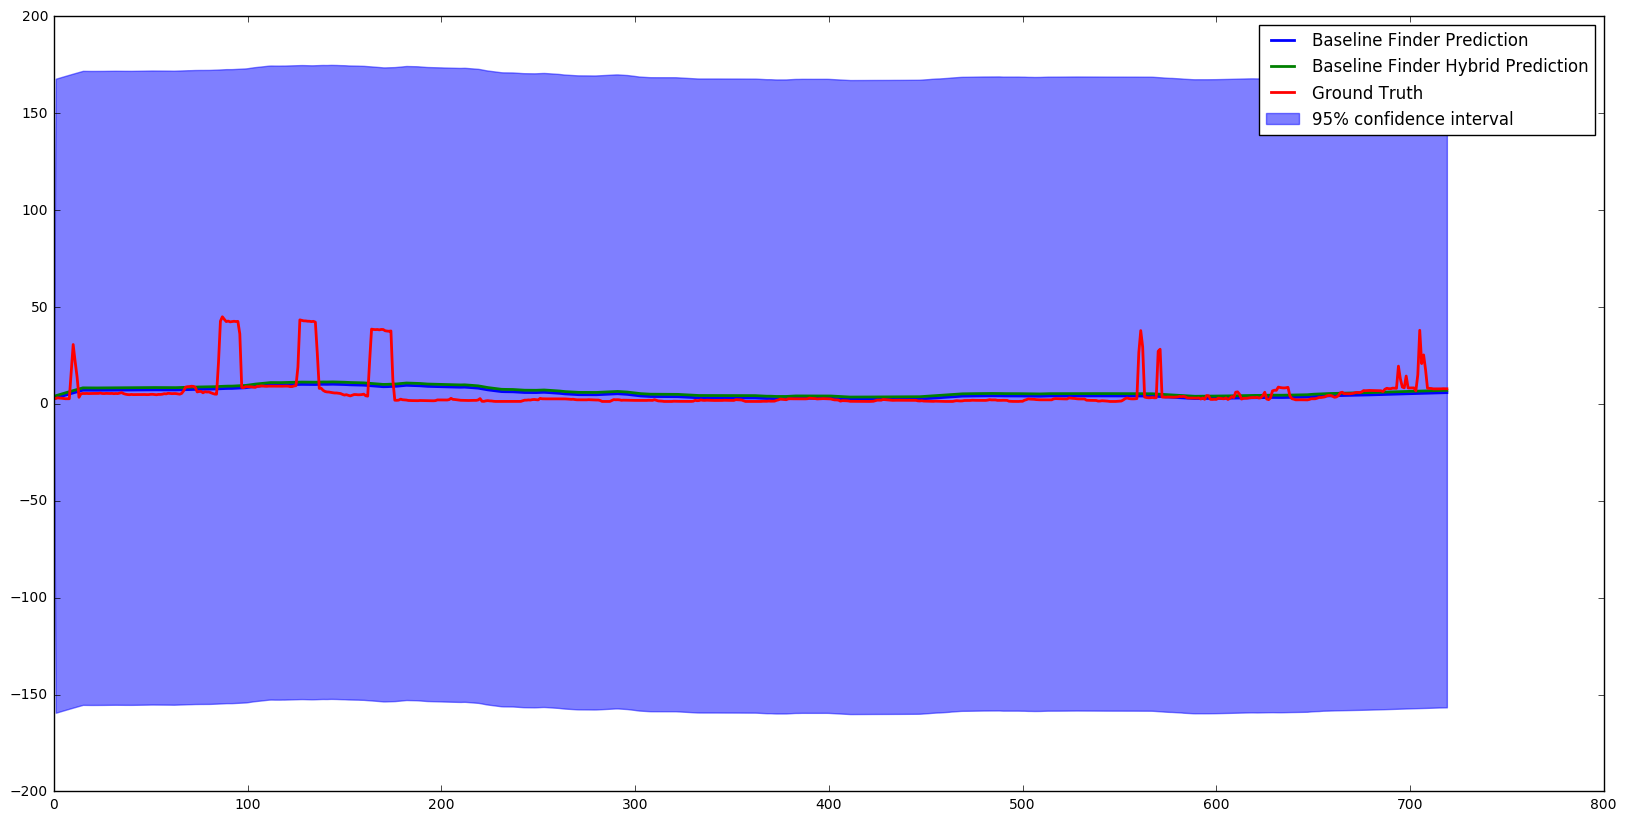

In [8]:
PlotSimplePrediction(tester, 40, {"Baseline Finder", "Baseline Finder Hybrid"})


## IV. Usage Zone Finder

The last algorithm uses as a base the BLF. On top of this using a confidence threshold, it predicts spikes in the consumption.

This works by first running a low-pass filter to find the base consumption (exactly like before). Then we run a highpass filter to find spikes in consumption:

In [ ]:
from iec import highpass_filter
fig, axes = plt.subplots(2, figsize=(20,8), dpi=400)

axes[0].plot(data[-offset-ObservationLength:-offset, 2])
axes[1].plot(highpass_filter(data[-offset-ObservationLength:
                                 -offset, 2]))

axes[1].set_ylim(axes[0].get_ylim())

We suggest that each such region is an electrical appliance that has a probability of reappearing in a close time window. We try to match such regions in our similar days and create a probability for the future predictions.

For example we have what happened in two days, similar to our current one:

In [ ]:
fig, axes = plt.subplots(2, figsize=(20,8), dpi=400)

similar_day0 = KSimilarDays[0]
similar_day1 = KSimilarDays[1]
highpass = np.zeros((2, PredictionWindow))
highpass[0,:] = highpass_filter(TrainingData[similar_day0:
                                            similar_day0 + PredictionWindow,2])
highpass[1,:] = highpass_filter(TrainingData[similar_day1:
                                            similar_day1 + PredictionWindow,2])

axes[0].plot(highpass[0,:])
axes[1].plot(highpass[1,:])

We will pass a filter through the array (with shape k,PredictionWindow) that has a window of 3.
Then we calculate our confidence as:

Non-zero values in window / window.size

if our confidence is high enough we predict a spike sized

mean of non-zero values in window * confidence

In our example we have this:

In [ ]:
W = 3 # 2*W is a window in minutes where we will match two regions
confidence_threshold = 1/W #We totally ignore regions where we are not confident enough

paded_highpass = np.pad(highpass, ((0,),(W,)), mode='edge')

PredictionHighpass = np.zeros((1, PredictionWindow))

for i in range(W, PredictionWindow+W):
    window = paded_highpass[:, i-W:i+W]
    confidence = np.count_nonzero(window)/window.size

    if(confidence > confidence_threshold):
        PredictionHighpass[0, i-W] = np.mean(window[np.nonzero(window)])*confidence

fig, axes = plt.subplots(3, figsize=(20,8), dpi=400)
axes[0].plot(highpass[0,:])
axes[1].plot(highpass[1,:])
axes[2].plot(PredictionHighpass[0])
axes[2].set_ylim(axes[0].get_ylim())

Finally, the usual prediction using UZF: (hand-picked example that illustrates the advantage of UZF)

In [ ]:
PlotSimplePrediction(tester, 36015, {"Usage Zone Finder"})

##### <center>Testing Methods - Results</center>

### I.   RMSE of each minute into the future.

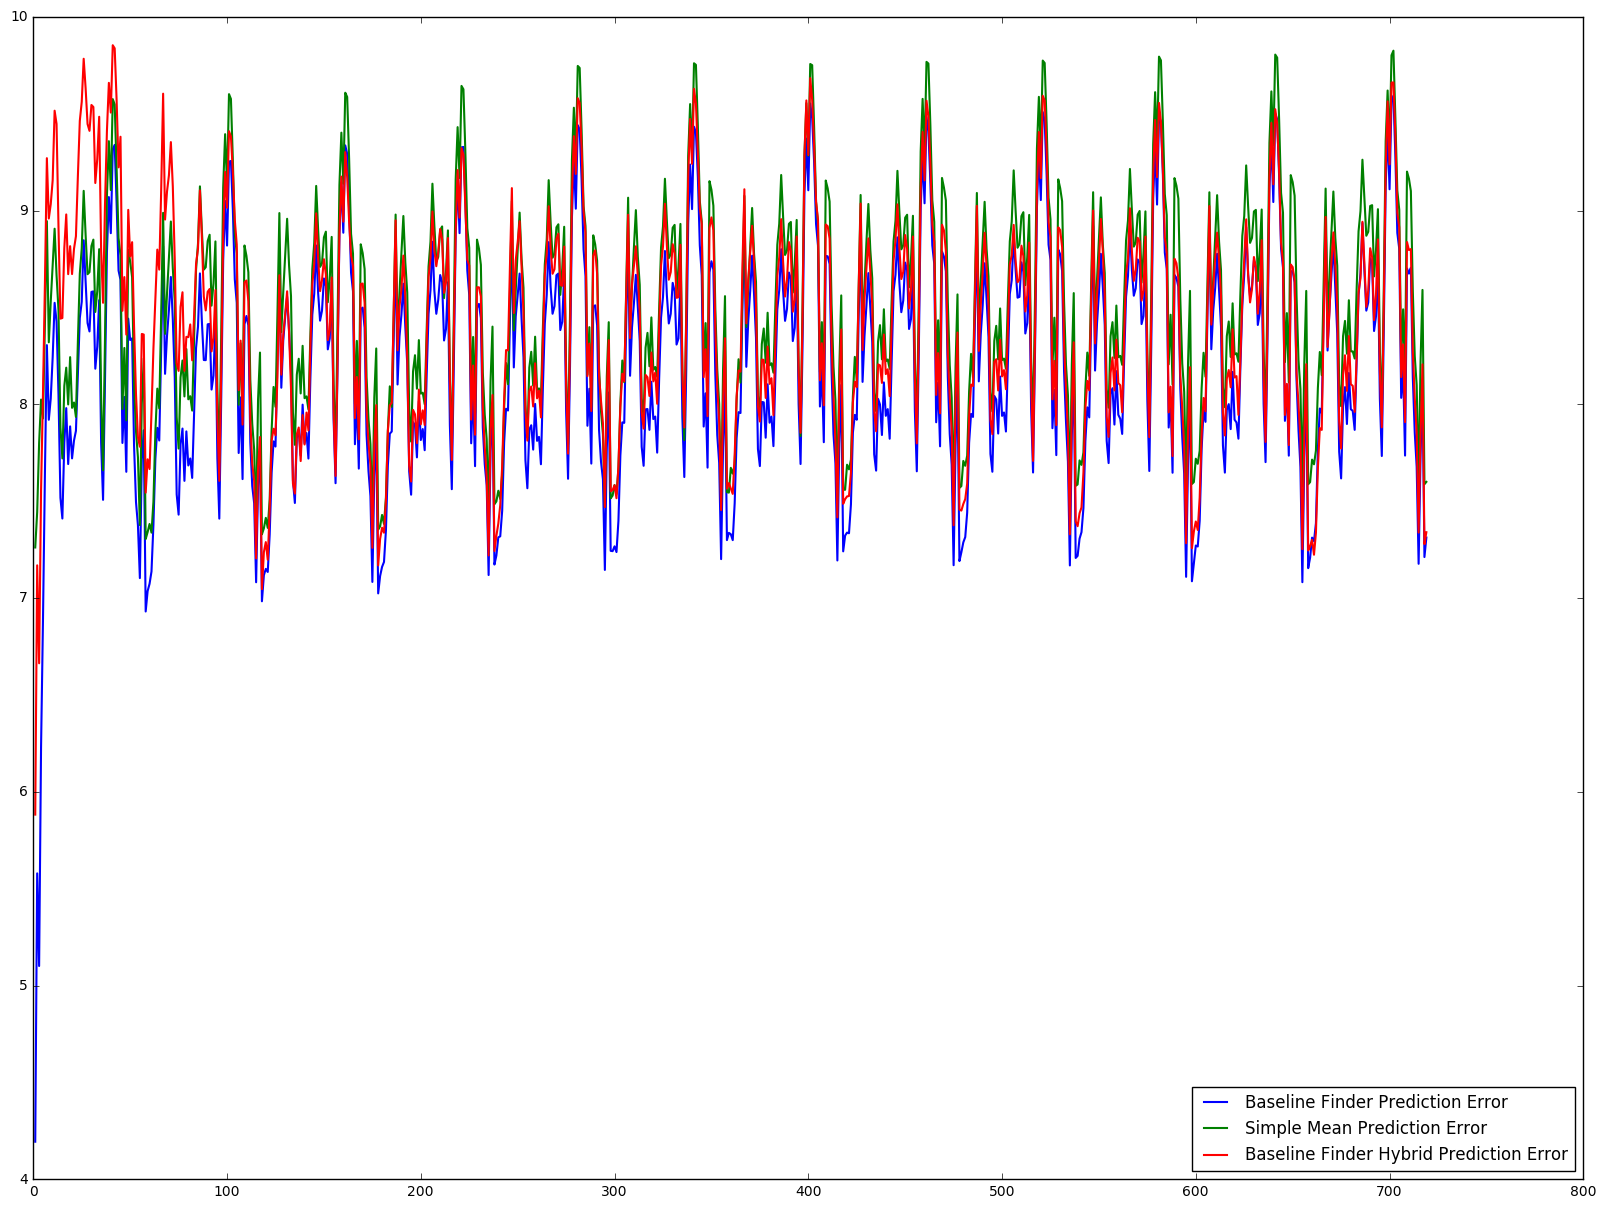

In [9]:
PlotRMSEperMin(tester)

### II.  Average RMSE of our predictions.

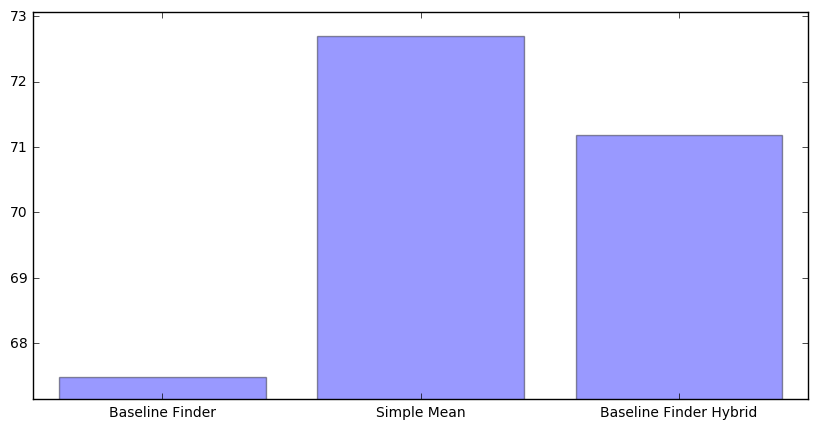

In [10]:
PlotAverageRMSE(tester)

### III. Average error of total consumption in the prediction window.

In [ ]:
PlotAverageTotalError(tester)

## IV. Finally a simple prediction of a random moment

In [ ]:
PlotSimplePrediction(tester, 25)